# Лабораторная работа №2.
## НАИВНЫЙ БАЙЕСОВСКИЙ КЛАССИФИКАТОР. МЕТОД ОПОПРНЫХ ВЕКТОРОВ
### Выполнил Энтентеев Айдар гр. Э-13м-19

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from collections import Counter 
from sklearn import feature_extraction 
from sklearn import model_selection 
from sklearn.naive_bayes import MultinomialNB 
from sklearn import metrics 
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import roc_curve 
from sklearn.metrics import auc 
from sklearn.svm import SVC 

### Загрузка данных для обучения. 

In [2]:
data = pd.read_csv('spam.csv',encoding='ISO-8859-1').drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)
data.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Вывод круговой диаграммы данных

Text(0, 0.5, '')

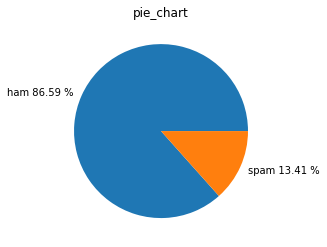

In [3]:
y = data["v1"]
X = data['v2']

target = pd.value_counts(y)
ns = str(round(target['ham']/(target['ham']+target['spam'])*100,2))
s = str(round(target['spam']/(target['ham']+target['spam'])*100,2))
target = target.rename({'ham':'ham '+ns+' %','spam':'spam ' +s+ ' %'})
target.plot(kind = 'pie') 
plt.title('pie_chart') 
plt.ylabel('') 


### Вывод гистаграммы наиболее встречающихся слов

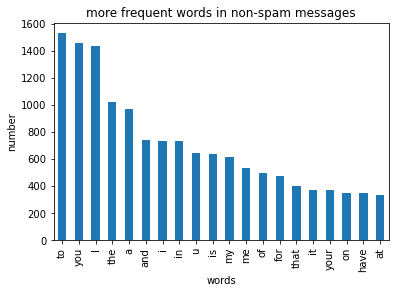

In [4]:
ham_words = Counter(' '.join(data[data['v1']=='ham']['v2']).split()).most_common(20) 
df_ham_words = pd.DataFrame.from_dict(ham_words) 
df_ham_words = df_ham_words.rename(columns={0: 'words in non‐spam',1:'count'}) 
df_ham_words.plot.bar(x= 'words in non‐spam',legend = False)
y_pos = np.arange(len(df_ham_words['words in non‐spam'])) 
plt.xticks(y_pos, df_ham_words['words in non‐spam']) 
plt.title('more frequent words in non‐spam messages') 
plt.xlabel('words') 
plt.ylabel('number') 
plt.show() 

### Токенизация данных для возможности применения к текстовым данным численных методов

In [5]:
tokenizer = feature_extraction.text.CountVectorizer(stop_words = 'english') 
X = tokenizer.fit_transform(data['v2']) 

y = pd.get_dummies(data['v1'])["spam"]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.33,shuffle = True) 

# Наивный байесовский классификатор

### Процесс поиска наболее оптимального значения alpha по частоте правильных ответов. Сглаживающий коэфициент alfa отвечает за учитывание отсутствующие в обучающих выборках данных, и предотвращают нулевые вероятности в дальнейших вычислениях.

In [6]:
alpha_range = np.arange(0.1, 20, 0.1) 
train_score = []
test_score = []
test_recall = []
test_precision = []


for i in alpha_range:
    model = MultinomialNB(alpha = i) 
    model.fit(X_train, y_train) 
    y_predict = model.predict(X_train)
    train_score.append(metrics.accuracy_score(y_train, y_predict))
    y_predict = model.predict(X_test)
    test_score.append(metrics.accuracy_score(y_test, y_predict))
    test_recall.append(metrics.recall_score(y_test, y_predict))
    test_precision.append(metrics.precision_score(y_test, y_predict))

In [22]:
alpha = {'alpha': np.arange(0.1, 20, 0.1)}
kf = KFold(n_splits=5,shuffle=True)
model = MultinomialNB()
gs = GridSearchCV(model, alpha, scoring='accuracy', cv=kf)
gs.fit(X, y)
print(gs.best_params_)
print(gs.best_score_)

{'alpha': 3.4000000000000004}
0.9840271795573662


In [23]:
matrix  =  np.matrix(np.c_[alpha_range,  train_score,  test_score,  test_recall, 
test_precision]) 
models = pd.DataFrame(data = matrix,  columns =  ['alpha',  'train accuracy', 
'test accuracy', 'test recall', 'test precision']) 

In [24]:
best_value = models['test precision'].max()
# best_index = models['test precision'].idxmax() 
best_index = models['test accuracy'].idxmax() 

## Вывод обучения алгоритма, достаточно низкое значение

In [25]:
%%time
model = MultinomialNB(alpha = alpha_range[best_index]) 
model.fit(X_train, y_train) 

CPU times: user 1.57 ms, sys: 3.99 ms, total: 5.56 ms
Wall time: 3.97 ms


MultinomialNB(alpha=3.0000000000000004)

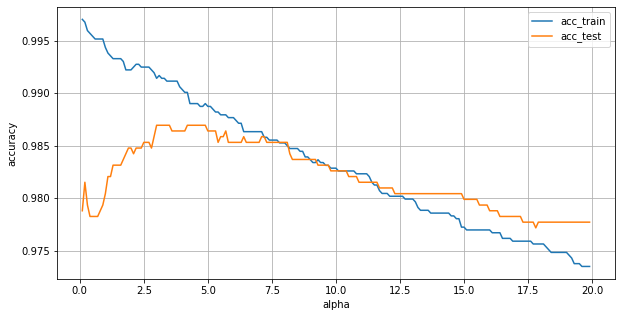

In [10]:
model = MultinomialNB(alpha = alpha_range[best_index]) 
model.fit(X_train, y_train) 

plt.figure(figsize = [10,5])
plt.plot(alpha_range,train_score)
plt.plot(alpha_range,test_score)
plt.grid("on")
plt.xlabel('alpha')
plt.ylabel('accuracy')
plt.legend(["acc_train","acc_test"])

### Из графика видно, что оптимальное значение alpha~3:5. при это частота правильных ответов ~ 0.985

### Матрица ошибок. Видно что FP=7, FN = 17 имеют достаточно низкие значения

In [11]:
confusion_matrix1 = confusion_matrix(y_test, model.predict(X_test)) 
pd.DataFrame(data  =  confusion_matrix1,  columns  =  ['predicted  ham', 
'predicted spam'], index = ['actual ham', 'actual spam']) 

,predicted ham,predicted spam
actual ham,1607,7
actual spam,17,208


### Площадь под AUC-ROC кривой

In [13]:
y_pred_pr = model.predict_proba(X_test)[:,1] 
fpr, tpr, threshold = metrics. roc_curve (y_test, y_pred_pr) 
roc_auc = metrics.auc(fpr, tpr) 
print(roc_auc)

0.9881619636644762


### Построение AUC-ROC кривой

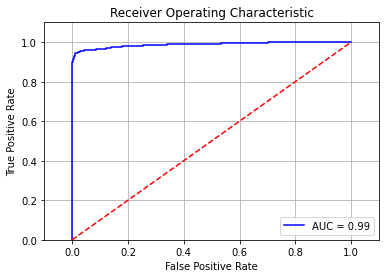

In [14]:
plt.title('Receiver Operating Characteristic') 
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc) 
plt.legend(loc = 'lower right') 
plt.plot([0, 1], [0, 1],'r--') 
plt.xlim([-0.1, 1.1]) 
plt.ylim([0, 1.1]) 
plt.ylabel('True Positive Rate') 
plt.xlabel('False Positive Rate') 
plt.grid('on') 
plt.show() 

# Вывод:
## В данном части был реализован наивный байесовский алгоритм с подбором оптимального значения alpha

# SVM

### Процесс поиска наболее оптимального значения C по частоте правильных ответов. C - L2 коэфициент регуляризации

In [12]:
C= {'C': np.arange(0.01, 3, 0.1)}
kf = KFold(n_splits=5,shuffle=True)
model = SVC()
gs = GridSearchCV(model, C, scoring='accuracy', cv=kf)
gs.fit(X, y)
print(gs.best_params_)
print(gs.best_score_)

{'C': 2.41}
0.9809775301704358


In [13]:
c_range = np.arange(0.01, 3, 0.1) 
train_score = []
test_score = []
test_recall = []
test_precision = []


for i in c_range:
    model = SVC(C = i) 
    model.fit(X_train, y_train) 
    y_predict = model.predict(X_train)
    train_score.append(metrics.accuracy_score(y_train, y_predict))
    y_predict = model.predict(X_test)
    test_score.append(metrics.accuracy_score(y_test, y_predict))
    test_recall.append(metrics.recall_score(y_test, y_predict))
    test_precision.append(metrics.precision_score(y_test, y_predict))


/home/aidar/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
matrix  =  np.matrix(np.c_[c_range,  train_score,  test_score,  test_recall, 
test_precision]) 
models = pd.DataFrame(data = matrix,  columns =  ['C',  'train accuracy', 
'test accuracy', 'test recall', 'test precision']) 


In [16]:
best_value = models['test precision'].max()
# best_index = models['test precision'].idxmax() 
best_index = models['test accuracy'].idxmax()

## Вывод обучения алгоритма, значение выше, чем у байесовского алгоритма

In [14]:
%%time
model = SVC(C = c_range[best_index],probability = True) 
model.fit(X_train, y_train) 

CPU times: user 3.13 s, sys: 3.98 ms, total: 3.13 s
Wall time: 3.13 s


SVC(C=2.91, probability=True)

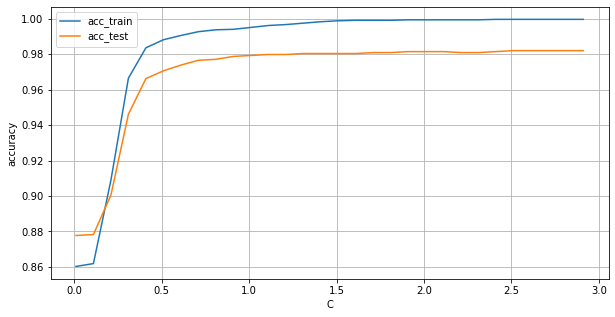

In [17]:
model = SVC(C = c_range[best_index],probability = True) 
model.fit(X_train, y_train) 

plt.figure(figsize = [10,5])
plt.plot(c_range,train_score)
plt.plot(c_range,test_score)
plt.grid("on")
plt.xlabel('C')
plt.ylabel('accuracy')
plt.legend(["acc_train","acc_test"])

### Из графика видно, как увеличение C ведет к увеличение accuracy

### Матрица ошибок. Видно что FP=1, FN = 32 имеют достаточно низкие значения. При этом значение precision равно 1613/(1613+1) = 0,99, такому алгоритму можно двоерять при выдаче класса 1, а recall равно 1613/(1613+32) = 0.98, также достаточно высокое значение, показывающее как мало ложных срабатваний

In [18]:
confusion_matrix1 = confusion_matrix(y_test, model.predict(X_test)) 
pd.DataFrame(data  =  confusion_matrix1,  columns  =  ['predicted  ham', 
'predicted spam'], index = ['actual ham', 'actual spam']) 

,predicted ham,predicted spam
actual ham,1613,1
actual spam,32,193


In [20]:
precision = 1613/(1613+1)
print(precision)
recall = 1613/(1613+32)
print(recall)

0.9993804213135068
0.9805471124620061


### Площадь под AUC-ROC кривой

In [22]:
y_pred_pr = model.predict_proba(X_test)[:,1] 
fpr, tpr, threshold = metrics. roc_curve (y_test, y_pred_pr) 
roc_auc = metrics.auc(fpr, tpr) 
print(roc_auc)

0.9946773340386142


### Построение AUC-ROC кривой

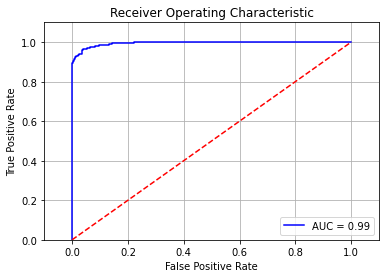

In [23]:
plt.title('Receiver Operating Characteristic') 
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc) 
plt.legend(loc = 'lower right') 
plt.plot([0, 1], [0, 1],'r--') 
plt.xlim([-0.1, 1.1]) 
plt.ylim([0, 1.1]) 
plt.ylabel('True Positive Rate') 
plt.xlabel('False Positive Rate') 
plt.grid('on') 
plt.show() 

# Вывод
## В данной работе были проверена работоспособность двух алгоритмов: метод опорных веторов и наивный байесовский алгоритм (НБА). 
## В теории хоть метод опорных веторов работает с малым количеством данных из выборки (с опрными векторами), но его время обучения длится дольше, чем у НБА
## Однако оба алгоритма показали хорошее качество в способности классификации писем 